[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbg-research/AI-Training/blob/main/voice-analytics/recognition/Tutorial-1.ipynb)

# Speech Recognition using GMM-HMM
Hidden Markov Models (HMMs) are powerful, flexible methods for representing and classifying data with trends over time, and have been a key component in speech recognition systems for many years.

# Data

To demonstrate this single speech recognition algorithm, I have used the HMM speech recognition data from google code project by Hakon Sandsmark. To download the data [click here.](https://code.google.com/p/hmm-speech-recognition/downloads/list)

In [1]:
# Importing the required libraries
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import tarfile
import os

In [3]:
# loading the dataset
tar = tarfile.open("audio.tar.xz", "r:xz")

In [4]:
# printing the spoken words in the dataset
fpaths = []
labels = []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        fpaths.append('audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['kiwi', 'peach', 'banana', 'orange', 'apple', 'lime', 'pineapple']


This data has a total of 7 different spoken words, and each was spoken 15 different times, giving a grand total of 105 files.

In the following codes, the files will be extracted into a single data matrix (zero padding files to uniform length), and a label vector with the correct label for each data file will be  created.

In [25]:
# extracting the files into single data matrix
from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Feature Extraction

Once the files in the data is turned into a single data matrix, the next step is to extract features from the raw data. Here, we will use simple frequency peak detection for feature extraction.

In order to find peaks in frequency, a technique called the Short Time Fourier Transform (STFT) is used. This idea is quite simple - the FFT is applied over chunks of the input data, resulting in a 2D FFT "image", usually called the spectrogram. Setting the FFT size allows us to control the amount of frequency resolution available, while overlapping these windows allows us to control the time resolution at the cost of increasing the data size.

In [27]:
# Defining the STFT function 
def stft(x, fftsize=64, overlap_pct=.5):   
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

(216, 32)


<ipython-input-27-5ce43eb75b34>:5: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Text(0.5, 1.0, 'PSD of kiwi example')

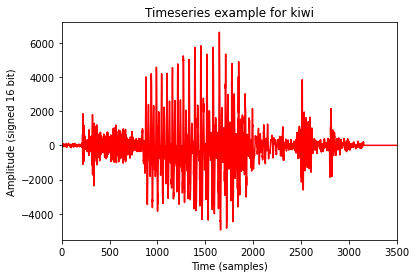

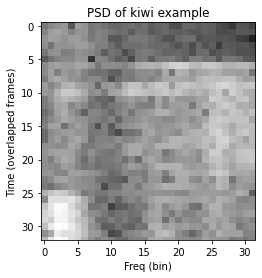

In [29]:
# Plotting the STFT
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='red')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

Next, peak detection is applied to each FFT frame of every data file. Here, we will use moving window to search for peaks.



The primary steps to this algorithm are as follows:

1. Create a data window of length X. Any window size can be used.
2. Split this window into 3 sections: left, center and right. 
3. Apply some function (mean, median, max, min, etc) over each section of the window.
4. If the maximum value of the function over the center section is greater than the result for left or right, continue to the next check. Otherwise GOTO 6
5. If the maximum value for f(CCC) is in the very center of the window, you have found a peak! Mark it and continue. Otherwise, go to the next step.
6. Shift the input data by one sample, and repeat the process. 
7. Once all data has been processed, you should have some detected peaks. Sort them in descending order by amplitude, then output the top N peaks. In this case, N=6


An implementation of this algorithm is shown below.

In [8]:
# Defining function for peak detection
from numpy.lib.stride_tricks import as_strided

#Peak detection  
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

<ipython-input-27-5ce43eb75b34>:5: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Text(0, 0.5, 'Amplitude')

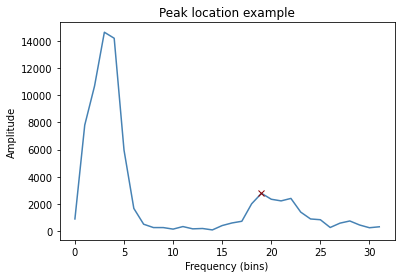

In [30]:
# Plotting the peak 
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
MFCC or deep NN/automatic feature extraction could be interesting for multispeaker.

In [10]:
# processing thge observation for finding top frequency peaks
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

<ipython-input-6-15826fc17379>:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100


# GMM-HMM
An implementation of a GMM-HMM is shown below.This implementation does not have any Viterbi backtracking - This code is manily focused on speech classification, only Baum-Welch and Forward-Backward portions of the GMM-HMM are necessary. We use Baum-Welch algorithm to train HMM.

In [11]:
# Implementing the GMM-HMM
import scipy.stats as st
import numpy as np

class gmmhmm:
    
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 221.38828575112734
M2: 165.27280230776495
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.19459421485196
M2: 59.15274753052998
Prediction for test set 2
Model 2


# Training and Testing
Once the peaks are detected for each frame, we have a 3 dimensional numpy array of size [numdatafiles, numpeaks, numframes] - in this case [105, 6, 216]. It is important that the observations be normalized in order to form probabilities, since the HMM expects to be trained on state probabilities.

For each sample, we have extracted a number of frames over time, and each frame has its own set of peaks. We divide each frame by the sum of all peaks in the frame, and form a "state probability" for each frame in our dataset. In essence, we are creating 6 states, where the highest peak in a frame is state 1, second highest state 2, etc. for each FFT frame.

In [31]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( all_obs, all_labels, test_size=0.1, random_state=0)

# to form state probability we divide each frame by the sum of all peaks in the frame.
for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

# Printing the size of training and testing datasets
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (94, 6, 216)
Size of testing matrix: (11, 6, 216)


To predict words, we need to train 7 separate GMM-HMM models, one for each word. We will then feed the features for a test sample into each, choosing the word associated with the GMM-HMM having the highest output likelihood. This maximum likelihood estimate is our best guess for what word was spoken.

In [32]:
# training and testing GMM-HMM
ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 63.64 percent


# Confusion Matrix

<ipython-input-33-aa9bf5e80126>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
<ipython-input-33-aa9bf5e80126>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([" "] + spoken)


Text(0.5, 0, 'Predicted label')

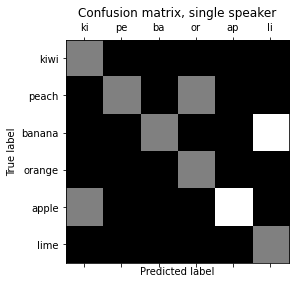

In [33]:
# plotting confusion matrix for finding the unsual pattern in missclassification.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')